The aim of this notebook is to implement a Vision Transformer (ViT) from scratch using PyTorch. We will go through the key steps involved in building a ViT model, including patch embedding, positional encoding, self-attention, and the final classification head.

In [27]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
import os

%config InlineBackend.figure_format = 'retina'

In [7]:
download_url = "https://images.unsplash.com/photo-1503023345310-bd7c1de61c7d"

if not os.path.exists("sample_image.jpg"):
    img = Image.open(requests.get(download_url, stream=True).raw)
    img.save("sample_image.jpg")

img = Image.open("sample_image.jpg")

(np.float64(-0.5), np.float64(2865.5), np.float64(3581.5), np.float64(-0.5))

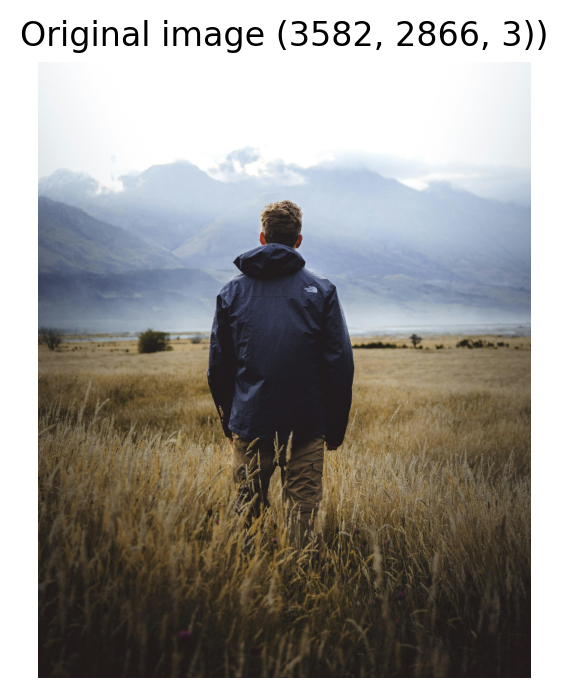

In [10]:
img_np = np.array(img)

plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.title(f"Original image {img_np.shape})")
plt.axis('off')

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

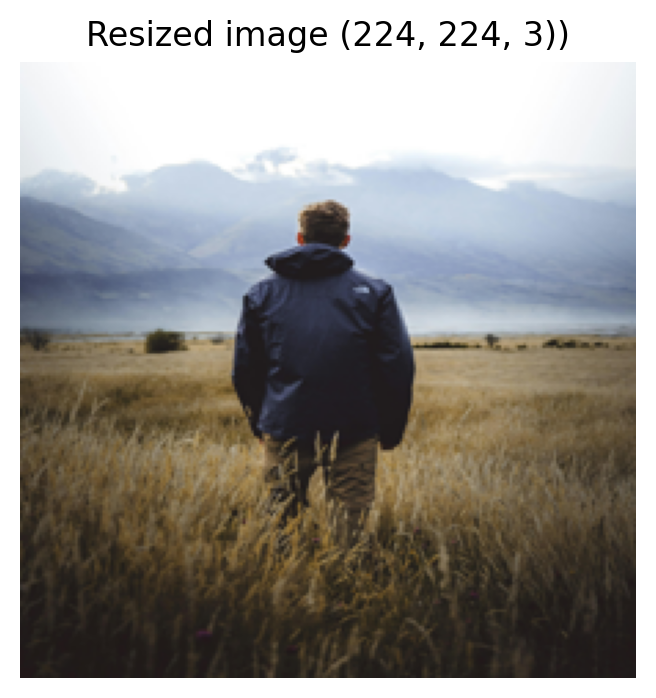

In [11]:
# Resize to 224x224
img = img.resize((224, 224))
img_np = np.array(img)
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.title(f"Resized image {img_np.shape})")
plt.axis('off')

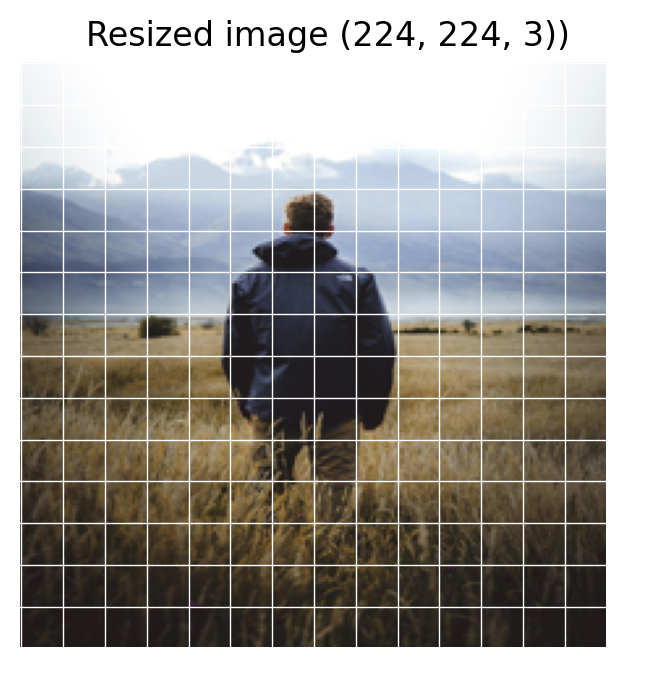

In [13]:
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.title(f"Resized image {img_np.shape})")
plt.axis('off')
# draw 16×16 grid lines
for i in range(0, 225, 16):
    plt.axhline(i, color='white', lw=0.5)
    plt.axvline(i, color='white', lw=0.5)
plt.axis('off')
plt.show()

In [14]:
# Number of patches
num_patches = (224 // 16) * (224 // 16)
print(f"Number of patches: {num_patches} (16x16 pixels each)")

Number of patches: 196 (16x16 pixels each)


Readying data for PyTorch model
1. permute the image from (H, W, C) to (C, H, W)
2. convert to torch tensor
3. add batch dimension using unsqueeze(0)
4. convert dtype to float


In [20]:
x = torch.tensor(img_np/255.).permute(2,0,1).unsqueeze(0).float()
print(x.shape)

torch.Size([1, 3, 224, 224])


Using Conv2d to extract patches

In [24]:
patch_size = 16
in_channels = 3
embed_dim = 64

conv = torch.nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
patches = conv(x)  
print(patches.shape)  

torch.Size([1, 64, 14, 14])


In [25]:
print("After Conv2d:", patches.shape)

# flatten to tokens [B, N, D]
patches = patches.flatten(2).transpose(1,2)
print("After flatten (B, N, D):", patches.shape)

After Conv2d: torch.Size([1, 64, 14, 14])
After flatten (B, N, D): torch.Size([1, 196, 64])


Add CLS token

In [29]:
B, N, D = patches.shape  # [1, 196, 64]
cls_token = nn.Parameter(torch.zeros(1, 1, D))  # learnable
print("CLS token shape:", cls_token.shape)
# expand cls_token to batch size
cls_token_expanded = cls_token.expand(B, -1, -1)
print("Expanded CLS token shape:", cls_token_expanded.shape)
# concatenate cls_token to patches
tokens = torch.cat([cls_token_expanded, patches], dim=1)  # [1, 197, 64]
print("After adding [CLS] token:", tokens.shape)

CLS token shape: torch.Size([1, 1, 64])
Expanded CLS token shape: torch.Size([1, 1, 64])
After adding [CLS] token: torch.Size([1, 197, 64])


Add positional embeddings

In [30]:
pos_embed = nn.Parameter(torch.zeros(1, N + 1, D))  # learnable
print("Positional embedding shape:", pos_embed.shape)
# add positional embeddings
tokens = tokens + pos_embed

print("After adding positional embeddings:", tokens.shape)

Positional embedding shape: torch.Size([1, 197, 64])
After adding positional embeddings: torch.Size([1, 197, 64])


Flatten to get class logits

We mimic the end of ViT: take [CLS] only to linear head.

In [31]:
head = nn.Linear(D, 10)   # CIFAR-10 example
cls_output = tokens[:, 0]  # [B, D] # take [CLS] token only
print("CLS output shape:", cls_output.shape)
logits = head(cls_output)  # [B, 10]
print("Final logits:", logits.shape)

CLS output shape: torch.Size([1, 64])
Final logits: torch.Size([1, 10])


| Stage                  | Operation        | Shape           |
| ---------------------- | ---------------- | --------------- |
| Input image            | (B, 3, 224, 224) |                 |
| Patchify               | Conv2d           | (B, 64, 14, 14) |
| Flatten                | tokens           | (B, 196, 64)    |
| Add [CLS]              | concat           | (B, 197, 64)    |
| Add position embedding | +                | (B, 197, 64)    |
| Take CLS → head        | Linear           | (B, 10)         |


| Stage                  | Operation        | Shape           |
| ---------------------- | ---------------- | --------------- |
| Input image            | (B, 3, 224, 224) |                 |
| Patchify               | Conv2d           | (B, 64, 14, 14) |
| Flatten                | tokens           | (B, 196, 64)    |
| Add [CLS]              | concat           | (B, 197, 64)    |
| Add position embedding | +                | (B, 197, 64)    |
| Take CLS → head        | Linear           | (B, 10)         |


Now, let us create a simple class for this no attention ViT model.

In [32]:
class NoAttentionViT(nn.Module):
    """
    Minimal Vision Transformer without attention.
    Demonstrates patch embedding, CLS token, and positional encoding only.
    """
    def __init__(self, img_size=224, patch_size=16, in_ch=3, embed_dim=64, num_classes=10):
        super().__init__()

        # Patch embedding: Conv2d with kernel=stride=patch_size
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)

        num_patches = (img_size // patch_size) ** 2

        # Learnable CLS token + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Simple linear head
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize (optional)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]

        # 1. Patchify
        x = self.patch_embed(x)               # [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)      # [B, N, D]

        # 2. Add CLS token
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)        # [B, N+1, D]

        # 3. Add positional embeddings
        x = x + self.pos_embed

        # 4. Take CLS token only → Linear head
        out = self.head(x[:, 0])              # [B, num_classes]
        return out

In [33]:
model = NoAttentionViT(img_size=224, patch_size=16, embed_dim=64, num_classes=10)
dummy = torch.randn(2, 3, 224, 224)
out = model(dummy)
print("Output shape:", out.shape)

Output shape: torch.Size([2, 10])


Now, let us add attention mechanism to our ViT model. First, let us see how to implement one attention head.

```text
        ┌────────────────────────────────────────────────────────────┐
        │                     Input tokens (x)                       │
        │   [CLS]   [P1]   [P2]   [P3]   ...   [P196]                │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
        ┌────────────────────────────────────────────────────────────┐
        │  Linear projections (shared for all tokens)                │
        │  Q = x W_Q ,  K = x W_K ,  V = x W_V                       │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
        ┌────────────────────────────────────────────────────────────┐
        │        Compute attention scores: Q × Kᵀ / √D               │
        │   Each token's query compares with every key → (N×N) map   │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
                ┌────────────────────────────┐
                │   Softmax over rows         │
                │   → attention weights       │
                └────────────────────────────┘
                          │
                          ▼
        ┌────────────────────────────────────────────────────────────┐
        │   Weighted sum of all V’s                                  │
        │   For each token i:  yᵢ = Σ_j (attnᵢⱼ × Vⱼ)                │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
        ┌────────────────────────────────────────────────────────────┐
        │   Output projection: y = (attn @ V) W_O                    │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
        ┌────────────────────────────────────────────────────────────┐
        │     Updated token representations (same shape: N×D)        │
        │   [CLS']  [P1']  [P2']  ...  [P196']                       │
        └────────────────────────────────────────────────────────────┘
                          │
                          ▼
              CLS' → Linear Head → Class logits
```


Linear Projections (shared for all tokens)

In [37]:
B, N, D = tokens.shape  # [1, 197, 64]
print("Tokens shape (B, N, D):", tokens.shape)

W_q = torch.randn(D, D)
W_k = torch.randn(D, D)
W_v = torch.randn(D, D)

Q = tokens @ W_q    # [B, N, D]
K = tokens @ W_k
V = tokens @ W_v

print("Q:", Q.shape, "K:", K.shape, "V:", V.shape)

Tokens shape (B, N, D): torch.Size([1, 197, 64])
Q: torch.Size([1, 197, 64]) K: torch.Size([1, 197, 64]) V: torch.Size([1, 197, 64])


In [ ]:
import math
K_transposed = K.transpose(-2, -1)  # [B, N, D] -> [B, D, N]
scores = (Q @ K_transposed) / math.sqrt(D)   # [B, N, D] @ [B, D, N] -> [B, N, N]
print("Attention scores:", scores.shape)


Attention scores: torch.Size([1, 197, 197])


Text(0, 0.5, 'Query positions')

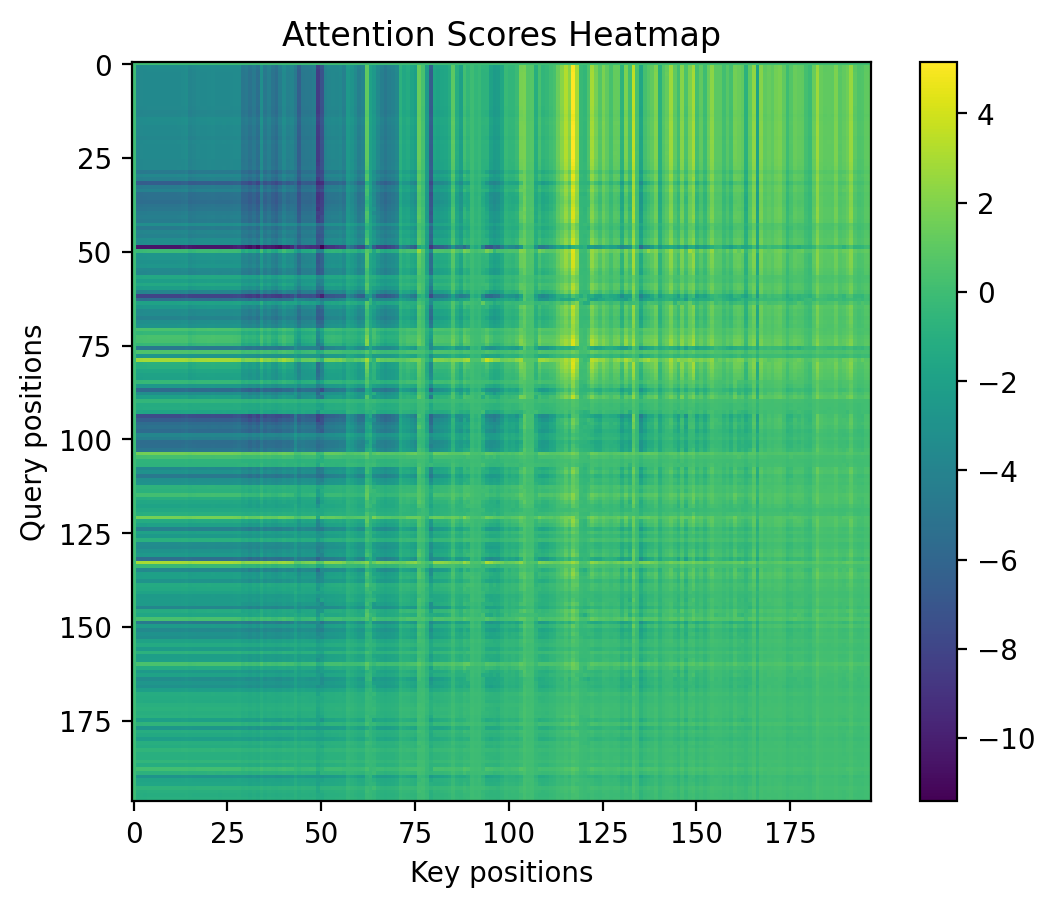

In [40]:
plt.imshow(scores[0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Scores Heatmap")
plt.xlabel("Key positions")
plt.ylabel("Query positions")

In [39]:
attn = torch.softmax(scores, dim=-1)
print("Attention weights:", attn.shape)

Attention weights: torch.Size([1, 197, 197])


Text(0, 0.5, 'Query positions')

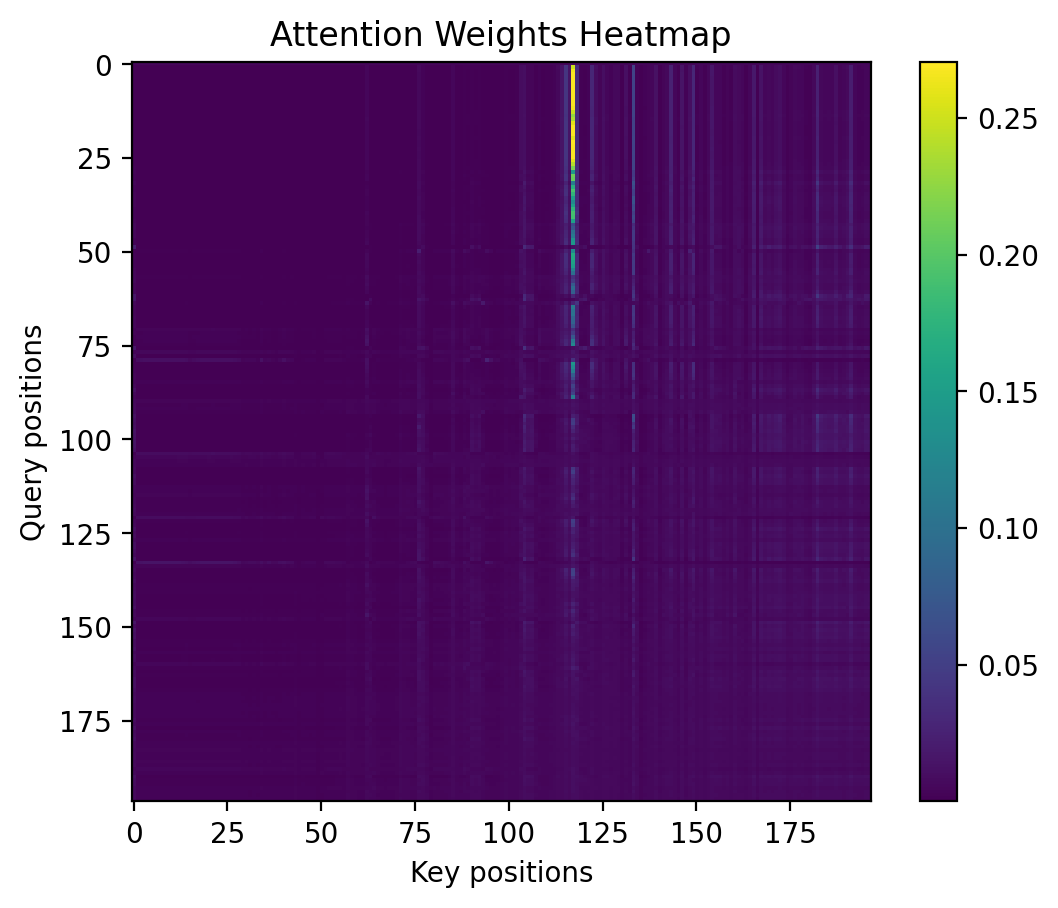

In [42]:
plt.imshow(attn[0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Weights Heatmap")
plt.xlabel("Key positions")
plt.ylabel("Query positions")

In [43]:
out = attn @ V     # [B, N, D]
print("Attention output:", out.shape)

Attention output: torch.Size([1, 197, 64])


In [44]:
cls_token = out[:, 0]                  # [B, D]
head = torch.randn(D, 10)            # 10 CIFAR classes
logits = cls_token @ head
print("Final logits:", logits.shape)

Final logits: torch.Size([1, 10])


In [45]:
class SingleHeadAttentionViT(nn.Module):
    """
    Simplest Vision Transformer:
    - Patchify image using Conv2d
    - Add CLS + positional embeddings
    - Single-head self-attention (manual)
    - Classification head
    """
    def __init__(self, img_size=224, patch_size=16, in_ch=3,
                 embed_dim=64, num_classes=10):
        super().__init__()
        self.embed_dim = embed_dim

        # 1. Patch embedding
        self.patch_embed = nn.Conv2d(in_ch, embed_dim,
                                     kernel_size=patch_size, stride=patch_size)
        num_patches = (img_size // patch_size) ** 2

        # 2. CLS token + positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # 3. Single-head Attention parameters
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)
        self.W_o = nn.Linear(embed_dim, embed_dim)

        # 4. Classification head
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]

        # Patchify
        x = self.patch_embed(x)               # [B, D, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)      # [B, N, D]

        # Add CLS + Positional embeddings
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)        # [B, N+1, D]
        x = x + self.pos_embed

        # Manual Self-Attention
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        scores = (Q @ K.transpose(-2, -1)) / math.sqrt(self.embed_dim)  # [B,N,N]
        attn = torch.softmax(scores, dim=-1)
        attn_out = attn @ V                                              # [B,N,D]
        x = self.W_o(attn_out)

        # CLS token -> classification head
        cls_out = x[:, 0]                    # [B, D]
        out = self.head(cls_out)             # [B, num_classes]
        return out


In [46]:
model = SingleHeadAttentionViT(embed_dim=64)
dummy = torch.randn(1, 3, 224, 224)
out = model(dummy)
print("Output shape:", out.shape)

Output shape: torch.Size([1, 10])
